Code to solve and test the unsteady diffusion equation on the interval $[a,b]$ in space and $[0,T]$ in time:
\begin{align*}
  u_t&=u_{xx}, \qquad a < x < b,\; 0\leq t \leq T \\
  u(a,t)&=u(b,t)=0, \quad u(x,0) = g(x) 
\end{align*}
using the Forward Euler method. To simplify, we take $a=0$ and $b=1$.

* Import libraries

In [1]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
plt.rcParams.update(newparams)

* Function to construct tridiagonal matrices

In [6]:
def tridiag(v, d, w, N):
    # Help function 
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1)+d*np.diag(e)+w*np.diag(e[1:],1)
    return A

* Implement the solver. 

In [2]:
def forward_euler(g, M=10, N=100, T=0.5):
    # Solve the heat equation
    # u_t=u_xx, 0<=x<=1
    # with boundary conditions u(0,t)=u(1,t)=0
    # and initial values u(x,0)=g(x)
    # over the time interval from 0 to T.
    # Input: 
    #       g: initial function for t=0
    #       M, N: number of grid intervals in the x- and t directions
    #       T: end of integration
    # Output: 
    #       x, t: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution.

    # Set the stepsizes
    h = 1/M     # Stepsize in space
    k = T/N     # Stepsize in time

    r = k/h**2
    # Print the stepsizes, and r=k/h^2.
    print('h={:.4f}, k={:.4f}, r={:.4f}'.format(h,k,r))

    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,1,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = g(x)              # Initial values, endpoints included
    
    A = tridiag(r,1-2*r,r,M-1);

    # Main loop 
    for n in range(N):
        U[1:-1, n+1] = A.dot(U[1:-1,n])  # [1:-1] -> excluding endpoints
        # Endpoints stay the same
    return x, t, U

* Implement the plotting function

In [3]:
def plot_solution(x, t, U, txt='Solution'):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    T, X = np.meshgrid(t,x)
    # ax.plot_wireframe(T, X, U)
    ax.plot_surface(T, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(txt);

Example taken in consideration in this notebook.
Initial value:
\begin{align*}
    g(x)&=\sin(\pi x)
\end{align*}
Exact solution:
\begin{align}
    u(x,t)=e^{-\pi^2 t}\sin(\pi x)
\end{align}

In [4]:
# Example
def g(x):
    return np.sin(np.pi*x) 

# Exact solution:
def uex_1(x,t):  
    return  np.exp(-1*np.pi**2*t)*np.sin(np.pi*x)

* Solve it. 
* Plot the solution.
* Compare with the exact solution (if available)

h=0.0500, k=0.0013, r=0.5000


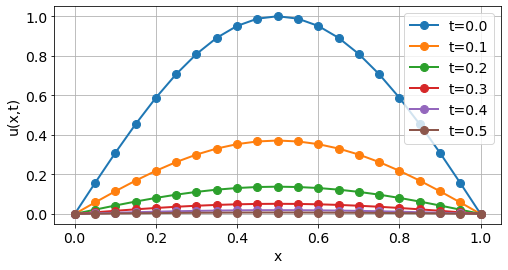

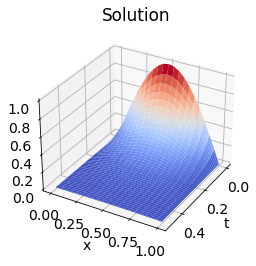

In [7]:
# Solve the equation
x, t, U = forward_euler(g, M=20, N=400, T=0.5)

# Plot the solution at some points in time
plt.figure(1)
plt.clf()
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    plt.plot(x,U[:,n],'-o',label='t={:.1f}'.format(tn))
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.show()

# Make a 3-d plot
plot_solution(x, t, U, txt='Solution')
plt.show()

* Plot the error

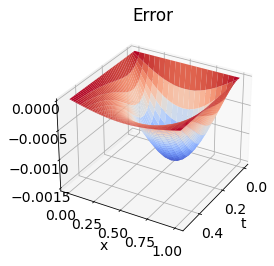

In [7]:
# Make a 3-d plot of the error
T, X = np.meshgrid(t,x)
plot_solution(x, t, U-uex_1(X,T), txt='Error')
plt.show()

* Verify the convergence result by successively refining the grid spatially. 

In [8]:
def convergence(u_exact, solver=forward_euler): 
    P = 4
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 2
    for p in range(P):
        x, t, U = solver(g, M=M, N=10000, T=0.1)
        Eh = u_exact(x,t[-1])-U[:,-1]
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh))
        M = 2*M
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

* Plot the log-log graph of convergence in time.

h=0.5000, k=0.0000, r=0.0000
h=0.2500, k=0.0000, r=0.0002
h=0.1250, k=0.0000, r=0.0006
h=0.0625, k=0.0000, r=0.0026


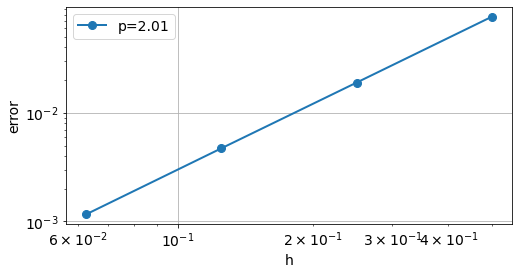

In [9]:
H, E, p = convergence(uex_1)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();

* Verify the convergence result by successively refining the grid temporally. 

In [14]:
x, t, U_ref = forward_euler(g, M=20, N=10000, T=0.1)
def convergence1(u_exact, solver=forward_euler): 
    P = 4
    Tconv = np.zeros(P)
    Econv = np.zeros(P)
    N = 400
    for p in range(P):
        x, t, U = solver(g, M=20, N=N, T=0.1)
        Eh = U_ref[:,-1]-U[:,-1]
        Tconv[p] = (t[1]-t[0])
        Econv[p] = np.max(np.abs(Eh))
        N = 2*N
    order = np.polyfit(np.log(Tconv),np.log(Econv),1)[0]
    return Tconv, Econv, order

h=0.0500, k=0.0000, r=0.0040


* Plot the log-log graph of convergence in time.

h=0.0500, k=0.0003, r=0.1000
h=0.0500, k=0.0001, r=0.0500
h=0.0500, k=0.0001, r=0.0250
h=0.0500, k=0.0000, r=0.0125


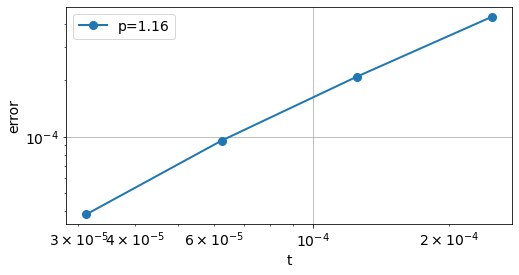

In [15]:
T, E, p = convergence1(uex_1)
plt.loglog(T,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('t')
plt.ylabel('error')
plt.legend();